In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import requests
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv('cleaned_data.csv')
df.head(5)

,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PubChem Standard Value,MolecularWeight,MolecularFormula,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,Hazard_clean
0,103191505,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,200.0,235.24,C10H13N5O2,2,6,2,17,"May cause skin irritation, damage, or burns"
1,103191505,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,200.0,235.24,C10H13N5O2,2,6,2,17,Causes eye damage or irritation
2,103191505,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,200.0,235.24,C10H13N5O2,2,6,2,17,"May cause breathing difficulties, respiratory ..."
3,103191505,20039,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,200.0,235.24,C10H13N5O2,2,6,2,17,May cause genetic defects
4,103220966,64975,C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Unspecified,70.0,233.23,C10H11N5O2,2,6,2,17,"May cause skin irritation, damage, or burns"


In [3]:
df['PUBCHEM_EXT_DATASOURCE_SMILES'] = df['PUBCHEM_EXT_DATASOURCE_SMILES'].dropna()

In [4]:
# smile grammar to encode compounds to integers and use lstm

smile = df[['PUBCHEM_EXT_DATASOURCE_SMILES', 'Hazard_clean']]

In [5]:
smile.dtypes

PUBCHEM_EXT_DATASOURCE_SMILES    object
Hazard_clean                     object
dtype: object

In [6]:
smile

,PUBCHEM_EXT_DATASOURCE_SMILES,Hazard_clean
0,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,"May cause skin irritation, damage, or burns"
1,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Causes eye damage or irritation
2,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,"May cause breathing difficulties, respiratory ..."
3,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,May cause genetic defects
4,C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,"May cause skin irritation, damage, or burns"
...,...,...
1558,CC1=C(C(=O)C2=C(C1=O)N3CCC(C3=N2)OC(=O)N)N4CC4,"May cause skin irritation, damage, or burns"
1559,CC1=C(C(=O)C2=C(C1=O)N3CCC(C3=N2)OC(=O)N)N4CC4,Causes eye damage or irritation
1560,CC1=C(C(=O)C2=C(C1=O)N3CCC(C3=N2)OC(=O)N)N4CC4,"May cause breathing difficulties, respiratory ..."
1561,CC1=C(C(=O)C2=C(C1=O)N3CCC(C3=N2)OC(=O)C)N4CC4,Harmful if swallowed or inhaled


In [7]:
drop = [
    'May cause cancer',
    'May cause genetic defects',
    'May cause damage to organs',
    'May cause drowsiness or dizziness',
    'May be corrosive to metals',
    'Flammable liquid and vapor'
]

smile = smile[~smile['Hazard_clean'].isin(drop)]

In [8]:
smile

,PUBCHEM_EXT_DATASOURCE_SMILES,Hazard_clean
0,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,"May cause skin irritation, damage, or burns"
1,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Causes eye damage or irritation
2,C1C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,"May cause breathing difficulties, respiratory ..."
4,C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,"May cause skin irritation, damage, or burns"
5,C1=C[C@@H](O[C@@H]1CO)N2C=NC3=C(N=CN=C32)N,Causes eye damage or irritation
...,...,...
1558,CC1=C(C(=O)C2=C(C1=O)N3CCC(C3=N2)OC(=O)N)N4CC4,"May cause skin irritation, damage, or burns"
1559,CC1=C(C(=O)C2=C(C1=O)N3CCC(C3=N2)OC(=O)N)N4CC4,Causes eye damage or irritation
1560,CC1=C(C(=O)C2=C(C1=O)N3CCC(C3=N2)OC(=O)N)N4CC4,"May cause breathing difficulties, respiratory ..."
1561,CC1=C(C(=O)C2=C(C1=O)N3CCC(C3=N2)OC(=O)C)N4CC4,Harmful if swallowed or inhaled


In [9]:
smiles_list = smile['PUBCHEM_EXT_DATASOURCE_SMILES'].unique().tolist()

In [10]:
all_chars = sorted(list(set("".join(smiles_list))))

In [11]:
char_to_int = {char: i for i, char in enumerate(all_chars)}

In [12]:
smile['SMILE_encoded'] = smile['PUBCHEM_EXT_DATASOURCE_SMILES'].apply(lambda x: [char_to_int[char] for char in x])

/var/folders/gw/6zvc4vx95yx8vrymkvc5m8zm0000gn/T/ipykernel_95041/703662706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smile['SMILE_encoded'] = smile['PUBCHEM_EXT_DATASOURCE_SMILES'].apply(lambda x: [char_to_int[char] for char in x])


In [13]:
smile.dtypes

PUBCHEM_EXT_DATASOURCE_SMILES    object
Hazard_clean                     object
SMILE_encoded                    object
dtype: object

In [14]:
y = smile['Hazard_clean']
X = smile.drop(['Hazard_clean', 'PUBCHEM_EXT_DATASOURCE_SMILES'], axis=1)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [16]:
x_train.iloc[0]

SMILE_encoded    [17, 17, 7, 14, 17, 1, 17, 1, 14, 22, 2, 17, 8...
Name: 1547, dtype: object

In [17]:
x_train = x_train['SMILE_encoded'].tolist()
# list of lists
x_test = x_test['SMILE_encoded'].tolist()

In [18]:
max_len = 100
x_train = pad_sequences(x_train, maxlen=max_len)
x_test  = pad_sequences(x_test,  maxlen=max_len)

In [19]:
type(x_train)

numpy.ndarray

In [20]:
x_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 17, 17,  7, 14, 17,  1, 17,  1, 14, 22,  2, 17,  8, 14,
       17,  1, 17,  7, 14, 22,  2, 21,  9, 17, 17, 17,  1, 17,  9, 14, 21,
        8,  2, 22, 17,  1, 14, 22,  2, 21,  2, 21, 10, 17, 17, 10],
      dtype=int32)

In [21]:
type(y_train)

pandas.core.series.Series

In [22]:
y_train.value_counts()

Hazard_clean
Causes eye damage or irritation                                                 210
May cause skin irritation, damage, or burns                                     194
Toxic if swallowed or inhaled                                                   146
May cause danger to unborn child, breastfed child, or fertility                 133
Harmful if swallowed or inhaled                                                 130
May cause breathing difficulties, respiratory irritation, or asthma symptoms    123
Fatal if swallowed, inhaled, or in contact with skin                             84
Toxic to aquatic life                                                            76
Name: count, dtype: int64

In [23]:
y_test.value_counts()

Hazard_clean
Causes eye damage or irritation                                                 53
May cause skin irritation, damage, or burns                                     49
Toxic if swallowed or inhaled                                                   36
Harmful if swallowed or inhaled                                                 33
May cause danger to unborn child, breastfed child, or fertility                 33
May cause breathing difficulties, respiratory irritation, or asthma symptoms    30
Fatal if swallowed, inhaled, or in contact with skin                            21
Toxic to aquatic life                                                           19
Name: count, dtype: int64

In [24]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [25]:
type(y_train)

numpy.ndarray

In [26]:
enc = OneHotEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_enc = enc.fit_transform(y_test.reshape(-1, 1)).toarray()

In [27]:
y_train_enc[0]

array([0., 0., 0., 1., 0., 0., 0., 0.])

In [28]:
print(f'y_train.shape: {y_train_enc.shape} \n')
print(f'x_train.shape: {x_train.shape} \n')
print(f'y_test.shape: {y_test_enc.shape} \n')
print(f'x_test.shape: {x_test.shape}')

y_train.shape: (1096, 8) 

x_train.shape: (1096, 100) 

y_test.shape: (274, 8) 

x_test.shape: (274, 100)


In [29]:
print(f'y_train before encoding: \n {y_train[0]}')
print(f'y_train encoded: \n {y_train_enc[0]}')

y_train before encoding: 
 May cause breathing difficulties, respiratory irritation, or asthma symptoms
y_train encoded: 
 [0. 0. 0. 1. 0. 0. 0. 0.]


In [30]:
max_x = 29

In [31]:
# embedding: set input dim as the largest integer corresponding with a word, choose output dim, input length
# means that each review will be truncated or padded based on the number of x integers 
# bidirectional: model reads the input forward and backward so it saves past, present, and future context - 
# captures later context that can help interpret previous context

lstm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = max_x + 1, output_dim = 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [32]:
optimizer = Adam(learning_rate=0.01)

In [33]:
lstm.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=optimizer
)

In [34]:
hist = lstm.fit(x_train, y_train_enc, epochs=100, validation_data=(x_test, y_test_enc))

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1478 - loss: 2.0611 - val_accuracy: 0.1934 - val_loss: 2.0270
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1889 - loss: 2.0275 - val_accuracy: 0.2044 - val_loss: 2.0153
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1880 - loss: 2.0127 - val_accuracy: 0.1861 - val_loss: 1.9771
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.1998 - loss: 1.9765 - val_accuracy: 0.1934 - val_loss: 1.9739
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.1998 - loss: 1.9747 - val_accuracy: 0.2226 - val_loss: 1.9442
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.2208 - loss: 1.9432 - val_accuracy: 0.2080 - val_loss: 1.9343
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.2454 - loss: 1.9122 - val_accuracy: 0.2372 - val_loss: 1.9428
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.2318 - loss: 1.8829 - val_accuracy: 0.

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3285 - loss: 1.5193 - val_accuracy: 0.2482 - val_loss: 2.1039
Epoch 52/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3276 - loss: 1.5147 - val_accuracy: 0.2372 - val_loss: 2.0990
Epoch 53/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3522 - loss: 1.4819 - val_accuracy: 0.2409 - val_loss: 2.1391
Epoch 54/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.3504 - loss: 1.4737 - val_accuracy: 0.2482 - val_loss: 2.2213
Epoch 55/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3266 - loss: 1.4790 - val_accuracy: 0.2299 - val_loss: 2.2053
Epoch 56/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.3339 - loss: 1.4757 - val_accuracy: 0.2336 - val_loss: 2.2377
Epoch 57/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3431 - loss: 1.4589 - val_accuracy: 0.2299 - val_loss: 2.2697
Epoch 58/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3403 - loss: 1.4781 - val_accuracy: 0.2445 

In [35]:
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │       132,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,608 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,586 (1.55 MB)

 Trainable params: 135,528 (529.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 271,058 (1.03 MB)

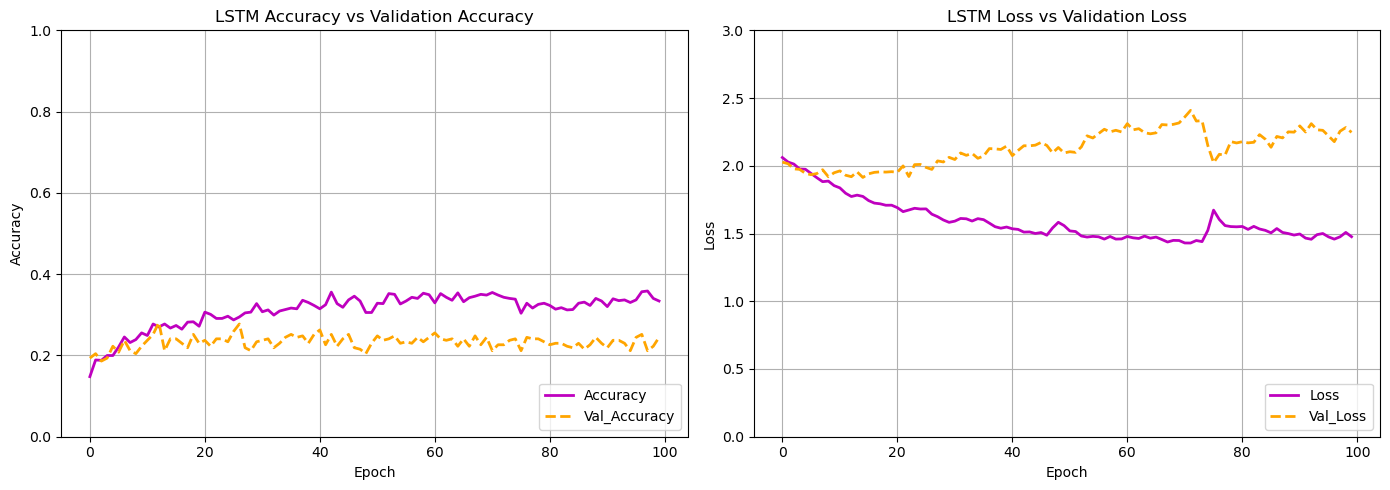

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(hist.history['accuracy'], label='Accuracy', c='m', linewidth=2, linestyle='-')
axes[0].plot(hist.history['val_accuracy'], label='Val_Accuracy', c='orange', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0.0, 1.0)
axes[0].grid(True)
axes[0].set_title('LSTM Accuracy vs Validation Accuracy')
axes[0].legend(loc='lower right')

axes[1].plot(hist.history['loss'], label='Loss', c='m', linewidth=2, linestyle='-')
axes[1].plot(hist.history['val_loss'], label='Val_Loss', c='orange', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_ylim(0.0, 3.0)
axes[1].grid(True)
axes[1].set_title('LSTM Loss vs Validation Loss')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [37]:
test_loss, test_accuracy = lstm.evaluate(x_test, y_test_enc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2445 - loss: 2.2469


In [38]:
predictions = lstm.predict(x_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


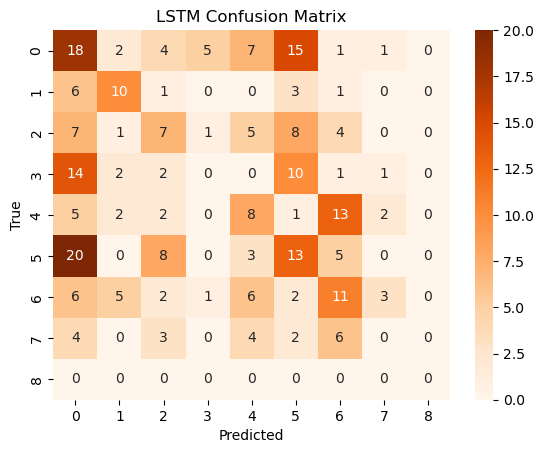

In [39]:
int_predictions = predictions.argmax(axis=1)
y_test_int = np.argmax(y_test_enc, axis=1)

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
cm = confusion_matrix(y_test_int, int_predictions, labels = labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM Confusion Matrix')
plt.show()